In [1]:
import numpy as np
import pandas as pd
import time
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Climate_data.csv')

In [3]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
0,2013-01-01,0.122271,0.840372,0.000000,0.132603,0.0,0.0,0.000000,0.166667
1,2013-01-02,0.042795,0.929054,0.070583,0.132881,0.0,0.0,0.033333,0.333333
2,2013-01-03,0.035662,0.869932,0.109743,0.132994,0.0,0.0,0.066667,0.500000
3,2013-01-04,0.081514,0.684685,0.029212,0.132799,0.0,0.0,0.100000,0.666667
4,2013-01-05,0.000000,0.867962,0.087636,0.132712,0.0,0.0,0.133333,0.833333


In [4]:
train = data[:-180]
test = data[-180:]
print(train.shape)
print(test.shape)

(1395, 9)
(180, 9)


In [5]:
x_train = train.drop(columns = {'date','meantemp'}, axis = 1)
y_train = train.loc[:, ['meantemp']]

x_test = test.drop(columns = {'date','meantemp'}, axis = 1)
y_test = test.loc[:, ['meantemp']]

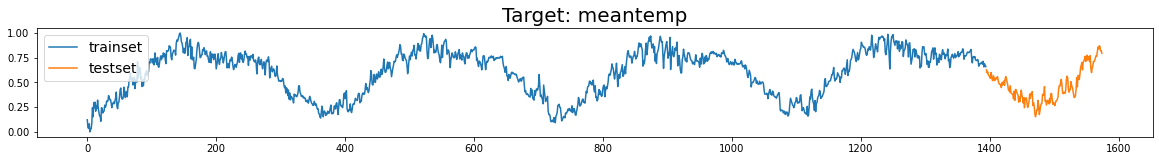

In [6]:
sns.reset_orig()
plt.figure(figsize = (20,2))
plt.title('Target: meantemp', fontsize = 20)
plt.plot(y_train['meantemp'], label = 'trainset')
plt.plot(y_test['meantemp'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# XGBoost

In [7]:
import xgboost

In [8]:
model = xgboost.XGBRegressor().fit(x_train, y_train)

pred = model.predict(x_test)
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)

print('R2: ', r2, '  ;  ', 'MSE: ', mse)

R2:  0.7756078203364389   ;   MSE:  0.008123421047937483


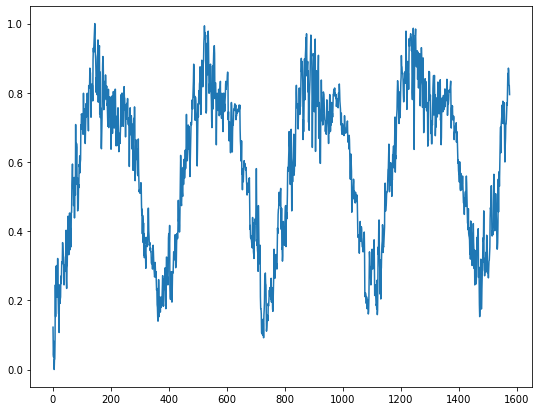

In [9]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (9,7))
#plt.title('Climate Data', fontsize = 24)
plt.plot(data['meantemp'], label = 'True')
#plt.plot(prediction, label = 'Pred')

#plt.legend()

plt.show()

# Interpretation of XGBoost

In [10]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [11]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 8
interp_x= x_train
model = model

ShapTime_xgb = ShapleyValues(model, interp_x, Tn)

In [12]:
ShapTime_xgb

[-0.012629449100372562,
 0.004192097817237861,
 -0.040656195441474356,
 0.03385272462428543,
 -0.05480730496201166,
 0.046124010966984784,
 -0.04682632119148777,
 0.07190227982505158]

In [13]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

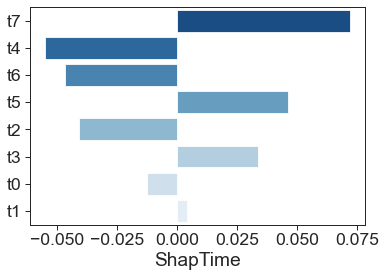

In [14]:
TimeImportance(Tn, ShapTime_xgb, time_columns)

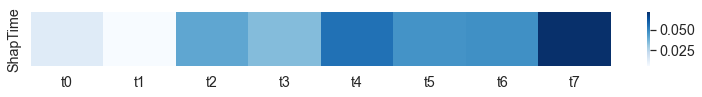

In [15]:
TimeHeatmap(Tn, ShapTime_xgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [16]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [17]:
n = 3
Tn = 8
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_xgb
model = xgboost.XGBRegressor()

In [18]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [19]:
result

,t0,t1,t2,t3,t4,t5,t6,t7
0,-0.012629,0.004192,-0.040656,0.033853,-0.054807,0.046124,-0.046826,0.071902
1,-0.012739,0.004262,-0.040622,0.033763,-0.054608,0.045989,-0.046900,0.072002
2,-0.012666,0.004332,-0.040624,0.033815,-0.054737,0.045749,-0.046872,0.072148
3,-0.012504,0.004085,-0.040753,0.033909,-0.054628,0.045957,-0.046955,0.072045


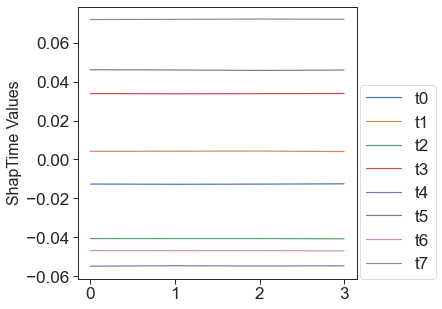

In [20]:
PlotVal(result)

### Sensitivity

In [21]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7]
situation_1 = [0, 1, 2, 3, 4, 5, 6, 1]
situation_2 = [0, 1, 2, 3, 0, 5, 6, 1]

In [22]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'date')
df_eva = supertime(8, train_eva)
model_eva = xgboost.XGBRegressor()

In [23]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [24]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'meantemp', model_eva, total)

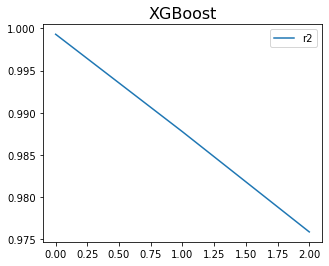

In [25]:
R2Plot(r2_results, 'XGBoost')

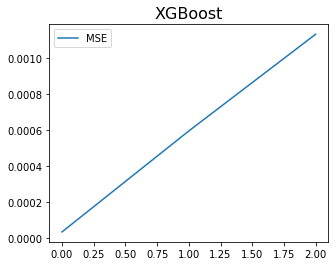

In [26]:
MSEPlot(mse_results, 'XGBoost')

# Improvement

In [27]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [28]:
check_replist = [t0, t7, t2, t3, t4, t5, t6, t7]

In [29]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'date','meantemp'}, axis = 1)
y_check = check.loc[:, ['meantemp']]

model_check = xgboost.XGBRegressor().fit(x_check, y_check)

pred_check = model_check.predict(x_test)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

0.7898682405923061 Degree of Improvement: 1.84%
0.007576520088115558 Degree of Improvement: 6.73%


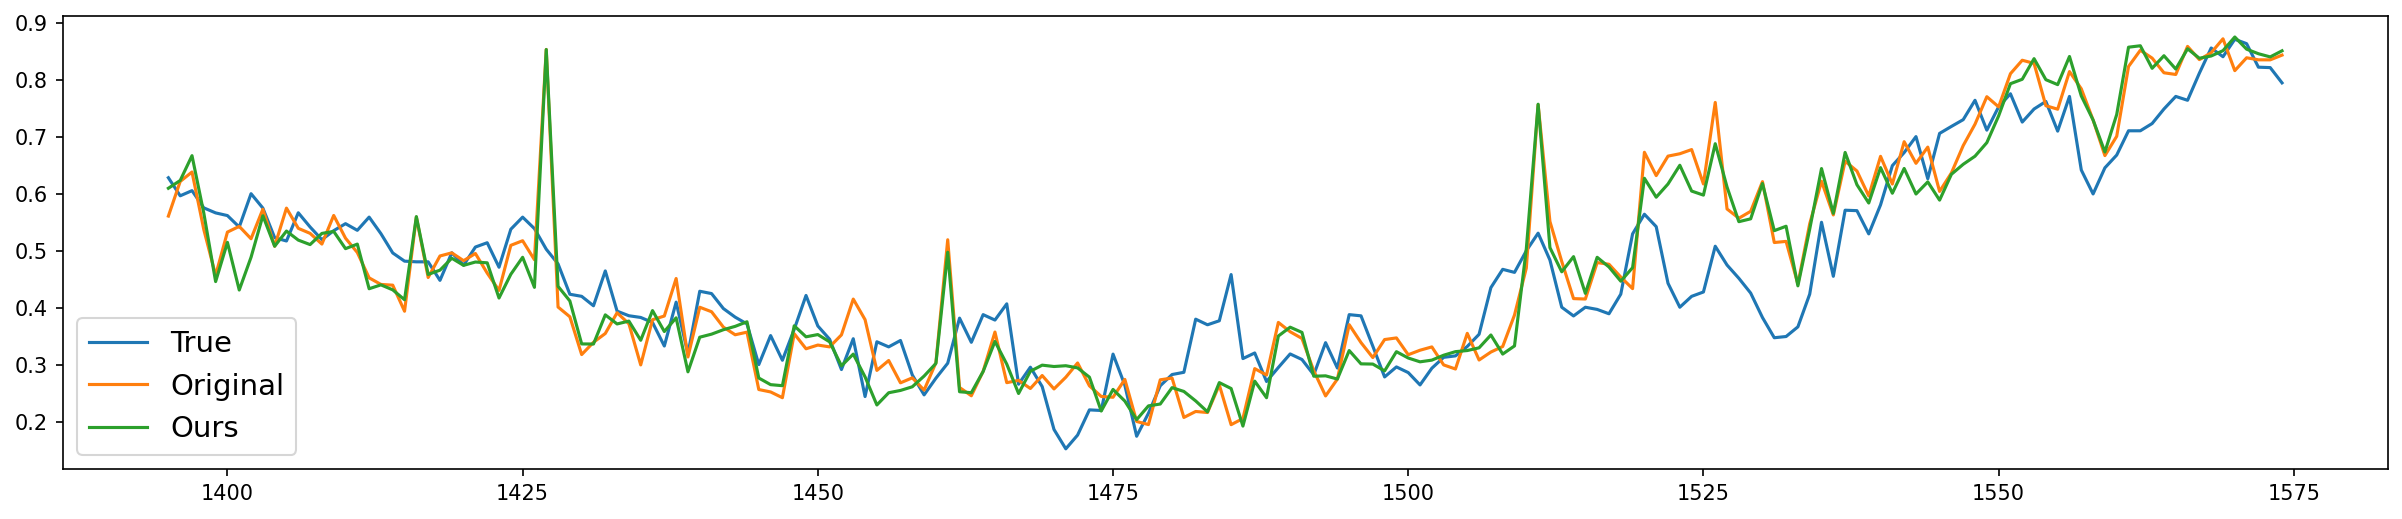

In [30]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['meantemp'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()

In [40]:
avg = sum(pred)/len(pred)

In [41]:
avg

0.4815219182107184

In [21]:
dfx[0]['humidity'] += 10*0.3

In [22]:
dfx[0]

,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
3,3.684685,0.029212,0.132799,0.0,0.000000,0.100000,0.666667
4,3.867962,0.087636,0.132712,0.0,0.000000,0.133333,0.833333
5,3.820270,0.035054,0.132907,0.0,0.000000,0.166667,1.000000
6,3.770608,0.149218,0.133167,0.0,0.000000,0.200000,0.000000
7,3.594595,0.169182,0.133000,0.0,0.000000,0.233333,0.166667
...,...,...,...,...,...,...,...
172,3.307095,0.254382,0.130069,0.0,0.454545,0.700000,0.833333
173,3.467905,0.197774,0.130000,0.0,0.454545,0.733333,1.000000
174,3.491554,0.313325,0.130081,0.0,0.454545,0.766667,0.000000
175,3.673986,0.263247,0.130456,0.0,0.454545,0.800000,0.166667


In [23]:
dfx.remove(dfx[0])

In [25]:
dfx[0]

,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
177,0.572635,0.188469,0.130136,0.0,0.454545,0.866667,0.500000
178,0.600929,0.208728,0.130043,0.0,0.454545,0.900000,0.666667
179,0.515203,0.328636,0.129946,0.0,0.454545,0.933333,0.833333
180,0.458052,0.248697,0.130195,0.0,0.454545,0.966667,1.000000
181,0.479730,0.206740,0.130099,0.0,0.545455,0.000000,0.000000
...,...,...,...,...,...,...,...
346,0.641892,0.275428,0.132126,0.0,1.000000,0.400000,0.666667
347,0.775338,0.018948,0.132200,0.0,1.000000,0.433333,0.833333
348,0.861064,0.060398,0.132533,0.0,1.000000,0.466667,1.000000
349,0.899493,0.027534,0.132598,0.0,1.000000,0.500000,0.000000


In [26]:
df = pd.concat(dfx, axis = 0)

In [27]:
df

,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
177,0.572635,0.188469,0.130136,0.00,0.454545,0.866667,0.500000
178,0.600929,0.208728,0.130043,0.00,0.454545,0.900000,0.666667
179,0.515203,0.328636,0.129946,0.00,0.454545,0.933333,0.833333
180,0.458052,0.248697,0.130195,0.00,0.454545,0.966667,1.000000
181,0.479730,0.206740,0.130099,0.00,0.545455,0.000000,0.000000
...,...,...,...,...,...,...,...
1390,0.426301,0.315563,0.131784,0.75,0.818182,0.700000,0.833333
1391,0.491099,0.273476,0.131776,0.75,0.818182,0.733333,1.000000
1392,0.449259,0.265004,0.131640,0.75,0.818182,0.766667,0.000000
1393,0.486351,0.293426,0.131726,0.75,0.818182,0.800000,0.166667


In [28]:
df_copy = df.copy()

In [31]:
df_copy

,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
177,0.572635,0.188469,0.130136,0.00,0.454545,0.866667,0.500000
178,0.600929,0.208728,0.130043,0.00,0.454545,0.900000,0.666667
179,0.515203,0.328636,0.129946,0.00,0.454545,0.933333,0.833333
180,0.458052,0.248697,0.130195,0.00,0.454545,0.966667,1.000000
181,0.479730,0.206740,0.130099,0.00,0.545455,0.000000,0.000000
...,...,...,...,...,...,...,...
1390,0.426301,0.315563,0.131784,0.75,0.818182,0.700000,0.833333
1391,0.491099,0.273476,0.131776,0.75,0.818182,0.733333,1.000000
1392,0.449259,0.265004,0.131640,0.75,0.818182,0.766667,0.000000
1393,0.486351,0.293426,0.131726,0.75,0.818182,0.800000,0.166667


In [30]:
df['humidity'] +=1

In [32]:
df

,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
177,1.572635,0.188469,0.130136,0.00,0.454545,0.866667,0.500000
178,1.600929,0.208728,0.130043,0.00,0.454545,0.900000,0.666667
179,1.515203,0.328636,0.129946,0.00,0.454545,0.933333,0.833333
180,1.458052,0.248697,0.130195,0.00,0.454545,0.966667,1.000000
181,1.479730,0.206740,0.130099,0.00,0.545455,0.000000,0.000000
...,...,...,...,...,...,...,...
1390,1.426301,0.315563,0.131784,0.75,0.818182,0.700000,0.833333
1391,1.491099,0.273476,0.131776,0.75,0.818182,0.733333,1.000000
1392,1.449259,0.265004,0.131640,0.75,0.818182,0.766667,0.000000
1393,1.486351,0.293426,0.131726,0.75,0.818182,0.800000,0.166667


In [34]:
dfx_copy = dfx.copy()

In [37]:
dfx_copy[0]

,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
177,0.572635,0.188469,0.130136,0.0,0.454545,0.866667,0.500000
178,0.600929,0.208728,0.130043,0.0,0.454545,0.900000,0.666667
179,0.515203,0.328636,0.129946,0.0,0.454545,0.933333,0.833333
180,0.458052,0.248697,0.130195,0.0,0.454545,0.966667,1.000000
181,0.479730,0.206740,0.130099,0.0,0.545455,0.000000,0.000000
...,...,...,...,...,...,...,...
346,0.641892,0.275428,0.132126,0.0,1.000000,0.400000,0.666667
347,0.775338,0.018948,0.132200,0.0,1.000000,0.433333,0.833333
348,0.861064,0.060398,0.132533,0.0,1.000000,0.466667,1.000000
349,0.899493,0.027534,0.132598,0.0,1.000000,0.500000,0.000000


In [11]:
dfx = supertime(8, x_train)

In [16]:
dfx[0].columns

Index(['humidity', 'wind_speed', 'meanpressure', 'Year', 'Month', 'Day',
       'Weekday'],
      dtype='object')

In [17]:
dfx[0].columns[0]

'humidity'

In [18]:
dfx[0][dfx[0].columns[0]]

3      0.684685
4      0.867962
5      0.820270
6      0.770608
7      0.594595
         ...   
172    0.307095
173    0.467905
174    0.491554
175    0.673986
176    0.686655
Name: humidity, Length: 174, dtype: float64

In [13]:
dfx[0]

,humidity,wind_speed,meanpressure,Year,Month,Day,Weekday
3,0.684685,0.029212,0.132799,0.0,0.000000,0.100000,0.666667
4,0.867962,0.087636,0.132712,0.0,0.000000,0.133333,0.833333
5,0.820270,0.035054,0.132907,0.0,0.000000,0.166667,1.000000
6,0.770608,0.149218,0.133167,0.0,0.000000,0.200000,0.000000
7,0.594595,0.169182,0.133000,0.0,0.000000,0.233333,0.166667
...,...,...,...,...,...,...,...
172,0.307095,0.254382,0.130069,0.0,0.454545,0.700000,0.833333
173,0.467905,0.197774,0.130000,0.0,0.454545,0.733333,1.000000
174,0.491554,0.313325,0.130081,0.0,0.454545,0.766667,0.000000
175,0.673986,0.263247,0.130456,0.0,0.454545,0.800000,0.166667


In [14]:
type(dfx)

list

In [19]:
for col in dfx[0].columns:
    print(col)

humidity
wind_speed
meanpressure
Year
Month
Day
Weekday
